In [1]:
import glob
from pathlib import Path

train_path = '../input/paddy-doctor-diseases-v2/train_images/'
test_path  = '../input/paddy-doctor-diseases-v2/test_images/'

print('train images')
for filepath in glob.glob(train_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")
    
print('test images')
for filepath in glob.glob(test_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

train images
1561 	 tungro
613 	 yellow_stem_borer
1720 	 hispa
694 	 downy_mildew
405 	 black_stem_borer
405 	 bacterial_leaf_streak
518 	 bacterial_leaf_blight
1004 	 brown_spot
1881 	 blast
876 	 leaf_roller
1924 	 normal
360 	 bacterial_panicle_blight
1019 	 white_stem_borer
test images
390 	 tungro
152 	 yellow_stem_borer
431 	 hispa
174 	 downy_mildew
101 	 black_stem_borer
100 	 bacterial_leaf_streak
130 	 bacterial_leaf_blight
253 	 brown_spot
470 	 blast
219 	 leaf_roller
481 	 normal
90 	 bacterial_panicle_blight
254 	 white_stem_borer


In [2]:
import numpy as np
import pandas as pd
import pickle
import cv2
import os

from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import keras
keras.__version__
from psutil import virtual_memory

SEED = 123
EPOCHS = 100
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
width = 256
height = 256
depth = 3

n_classes = len(glob.glob(train_path + '/*/'))
print(n_classes)

13


In [3]:
import os
from keras.models import Model
#from keras.optimizers import Adam
#from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.mobilenet import MobileNet, preprocess_input
#from keras.applications import MobileNet
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

#https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/
def create_model_mobilenet(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = MobileNet(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
#     model.add(Dense(1024))
#     model.add(Activation("relu"))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.5))
#     model.add(Dense(n_classes))
#     model.add(Activation("softmax"))
    
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

input_shape = (256, 256, 3)

# Use a smaller learning rate
optim_2 = Adam(lr=0.0001)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
model = create_model_mobilenet(input_shape, n_classes, optim_2, fine_tune=24)
model.summary()

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
2022-07-23 15:22:28.065095: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 15:22:28.193035: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 15:22:28.194216: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 15:22:28.197507: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized wi

17235968/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 128, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 128, 128, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 128, 128, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 128, 128, 32)      128       
______________________________________________________________

In [4]:
image_datagen = ImageDataGenerator(featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=5,
                 shear_range=0.2,
                 zoom_range=0.2,
                 width_shift_range=0.05,
                 height_shift_range=0.05,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 horizontal_flip=True,
                 vertical_flip=False,
                 rescale=1./255,
                                   validation_split=0.2)

train_generator = image_datagen.flow_from_directory(    
    directory = train_path,
    subset='training',
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=SEED)

valid_generator = image_datagen.flow_from_directory(    
    directory=train_path,
    subset='validation',
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=SEED)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(    
    directory=test_path,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=1,
    classes=['.'],
    class_mode=None,
    shuffle=False,
    seed=SEED)

print(train_generator.class_indices)
print(test_generator.samples)

Found 10389 images belonging to 13 classes.
Found 2591 images belonging to 13 classes.
Found 3245 images belonging to 1 classes.
{'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'black_stem_borer': 3, 'blast': 4, 'brown_spot': 5, 'downy_mildew': 6, 'hispa': 7, 'leaf_roller': 8, 'normal': 9, 'tungro': 10, 'white_stem_borer': 11, 'yellow_stem_borer': 12}
3245


In [5]:
try:
    from livelossplot.inputs.keras import PlotLossesCallback
except: 
    !pip install livelossplot

from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='mobilenet_model.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

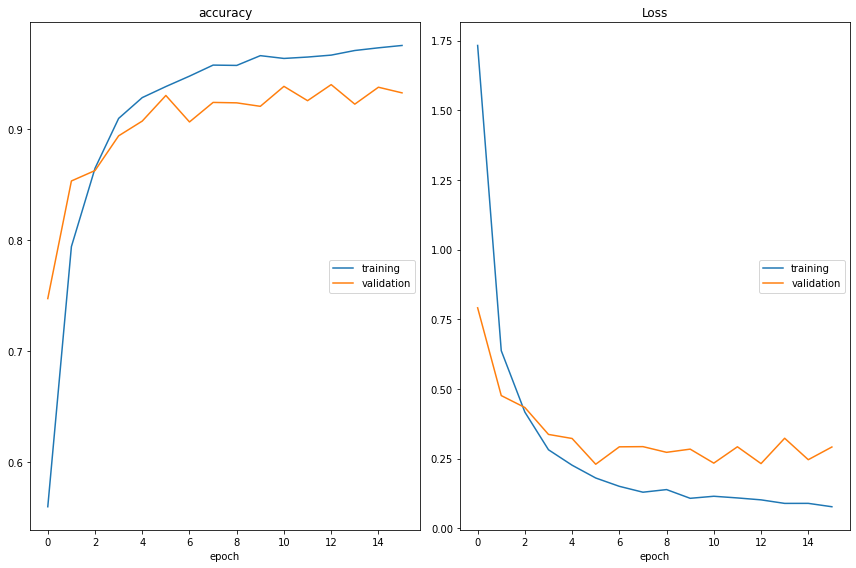

accuracy
	training         	 (min:    0.560, max:    0.975, cur:    0.975)
	validation       	 (min:    0.747, max:    0.940, cur:    0.932)
Loss
	training         	 (min:    0.078, max:    1.732, cur:    0.078)
	validation       	 (min:    0.230, max:    0.791, cur:    0.292)
CPU times: user 1h 3min 7s, sys: 50.9 s, total: 1h 3min 58s
Wall time: 1h 7min 40s


In [6]:
%%time

plot_loss_2 = PlotLossesCallback()

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

# Retrain model with fine-tuning
history = model.fit_generator(generator = train_generator,
                                  steps_per_epoch = STEP_SIZE_TRAIN,
                                  validation_data = valid_generator,
                                  validation_steps = STEP_SIZE_VALID,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1,epochs=EPOCHS)

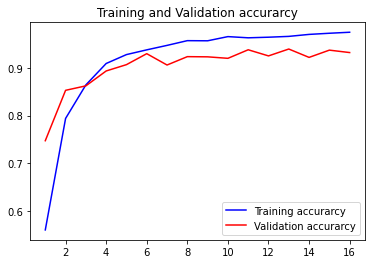

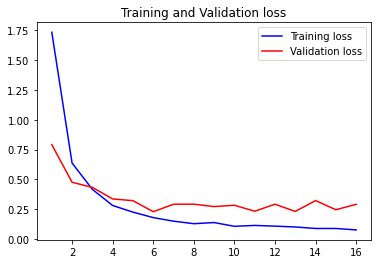

CPU times: user 459 ms, sys: 173 ms, total: 632 ms
Wall time: 373 ms


In [7]:
%%time
temp = pd.DataFrame(history.history)
temp.to_csv('model_mobilenet_history.csv', index=False)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [8]:
print('test images')
for filepath in glob.glob(test_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")
    
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(    
    directory=test_path,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=1,
    #classes=['.'],
    #class_mode="categorical",
    class_mode=None,
    shuffle=False,
    seed=SEED)

test images
390 	 tungro
152 	 yellow_stem_borer
431 	 hispa
174 	 downy_mildew
101 	 black_stem_borer
100 	 bacterial_leaf_streak
130 	 bacterial_leaf_blight
253 	 brown_spot
470 	 blast
219 	 leaf_roller
481 	 normal
90 	 bacterial_panicle_blight
254 	 white_stem_borer
Found 3245 images belonging to 13 classes.


In [9]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()

model.load_weights('mobilenet_model.weights.best.hdf5')
pred = model.predict_generator(test_generator,
                               steps=STEP_SIZE_TEST,
                               verbose=1)
pred_classes = np.argmax(pred, axis=1)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3245/3245 [==============================] - 43s 13ms/step


In [10]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

class_names = test_generator.class_indices.keys()
true_classes = test_generator.classes

acc = accuracy_score(true_classes, pred_classes)
print("mobilenet Model Accuracy : {:.2f}%".format(acc * 100))

cls_report = classification_report(true_classes, pred_classes, 
                                   target_names=class_names, digits=5)
print(cls_report)

mobilenet Model Accuracy : 92.42%
                          precision    recall  f1-score   support

   bacterial_leaf_blight    0.92437   0.84615   0.88353       130
   bacterial_leaf_streak    0.97727   0.86000   0.91489       100
bacterial_panicle_blight    1.00000   0.90000   0.94737        90
        black_stem_borer    0.95789   0.90099   0.92857       101
                   blast    0.91718   0.94255   0.92970       470
              brown_spot    0.85926   0.91700   0.88719       253
            downy_mildew    0.93373   0.89080   0.91176       174
                   hispa    0.90000   0.91879   0.90930       431
             leaf_roller    0.97753   0.79452   0.87657       219
                  normal    0.94960   0.97921   0.96418       481
                  tungro    0.88140   0.97179   0.92439       390
        white_stem_borer    0.95984   0.94094   0.95030       254
       yellow_stem_borer    0.94667   0.93421   0.94040       152

                accuracy                

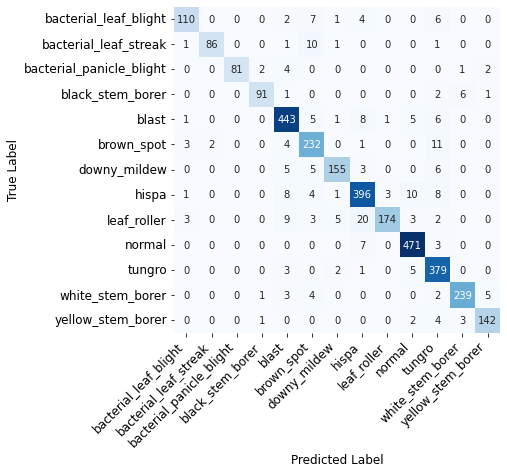

[[110   0   0   0   2   7   1   4   0   0   6   0   0]
 [  1  86   0   0   1  10   1   0   0   0   1   0   0]
 [  0   0  81   2   4   0   0   0   0   0   0   1   2]
 [  0   0   0  91   1   0   0   0   0   0   2   6   1]
 [  1   0   0   0 443   5   1   8   1   5   6   0   0]
 [  3   2   0   0   4 232   0   1   0   0  11   0   0]
 [  0   0   0   0   5   5 155   3   0   0   6   0   0]
 [  1   0   0   0   8   4   1 396   3  10   8   0   0]
 [  3   0   0   0   9   3   5  20 174   3   2   0   0]
 [  0   0   0   0   0   0   0   7   0 471   3   0   0]
 [  0   0   0   0   3   0   2   1   0   5 379   0   0]
 [  0   0   0   1   3   4   0   0   0   0   2 239   5]
 [  0   0   0   1   0   0   0   0   0   2   4   3 142]]


In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = test_generator.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_heatmap(true_classes, pred_classes, class_names, ax, title="CNN")    

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(top=1.25)
plt.show()
cm = confusion_matrix(true_classes, pred_classes)
print(cm)

In [12]:
loss, acc = model.evaluate_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)
print(acc, loss)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


3245/3245 [==============================] - 25s 8ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
0.0 0.0


In [13]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

pd.Series(predictions).value_counts()

normal                      496
blast                       483
hispa                       440
tungro                      430
brown_spot                  270
white_stem_borer            249
leaf_roller                 178
downy_mildew                166
yellow_stem_borer           150
bacterial_leaf_blight       119
black_stem_borer             95
bacterial_leaf_streak        88
bacterial_panicle_blight     81
dtype: int64

In [14]:
filenames=test_generator.filenames

results=pd.DataFrame({"image_id":filenames,
                      "label":predictions})
results.image_id = results.image_id.str.replace('./', '')
results.to_csv("submission.csv",index=False)
results.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


,image_id,label
0,bacterial_leaf_bligh200091.jpg,bacterial_leaf_blight
1,bacterial_leaf_bligh200112.jpg,brown_spot
2,bacterial_leaf_bligh200118.jpg,bacterial_leaf_blight
3,bacterial_leaf_bligh200133.jpg,bacterial_leaf_blight
4,bacterial_leaf_bligh200220.jpg,bacterial_leaf_blight
